In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
# Verilerinizi yükleyin
df = pd.read_csv('doviz_kuru.csv')

# Verileri zaman serisi modeline uygun hale getirmek için tarih sırasına göre düzenleyelim
# Verileri zaman serisi modeline uygun hale getirmek için tarih sırasına göre düzenleyelim
df['Tarih'] = pd.to_datetime(df['Tarih'], format='%d-%m-%Y')
df = df.sort_values(by='Tarih')

# Bu değerleri temizleyin
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Sonsuz değerleri NaN ile değiştir
df.dropna(inplace=True)  # Tüm NaN değerleri kaldır


# Sadece Altın fiyatı verisini alalım
eur_Values= df['EUR'].values.reshape(-1, 1)

# Verileri Min-Max ölçekleme ile normalleştirelim (LSTM için gerekli)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_EUR = scaler.fit_transform(eur_Values)


In [16]:
# Zaman serisi veri yapısı için bir yardımcı fonksiyon
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]  # X olarak
        X.append(a)
        Y.append(dataset[i + time_step, 0])  # Y olarak
    return np.array(X), np.array(Y)

# 60 adım (2 ay) geriye giderek veri setimizi hazırlayalım
time_step = 60
X, Y = create_dataset(scaled_EUR, time_step)

# Veriyi LSTM için uygun hale getirmek üzere yeniden şekillendirelim
X = X.reshape(X.shape[0], X.shape[1], 1)

# Eğitim ve test setlerini %80 - %20 oranında bölelim
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# LSTM modelini oluşturalım
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))  # %20 Dropout ekledik
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))  # %20 Dropout ekledik
model.add(Dense(25))
model.add(Dense(1))

# Modeli derleyelim
model.compile(optimizer='adamw', loss='mean_squared_error')

# EarlyStopping callback ile overfitting'i önlemek
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli eğitelim
history = model.fit(X_train, Y_train, batch_size=32, epochs=100, verbose=1, 
                    validation_data=(X_test, Y_test), callbacks=[early_stop])

Epoch 1/100


C:\Users\koylu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 7.0697e-04 - val_loss: 7.5833e-04
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4.7829e-05 - val_loss: 5.2537e-04
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 3.6139e-05 - val_loss: 0.0050
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3.6655e-05 - val_loss: 0.0011
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.5263e-05 - val_loss: 4.9062e-04
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.7114e-05 - val_loss: 5.9243e-04
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.9208e-05 - val_loss: 9.7446e-04
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.6641e-05 - val_loss: 8.6324e-04
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.4299e-05 - val_loss: 0.0032
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.8833e-05 - val_loss: 0.0020
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.86

123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


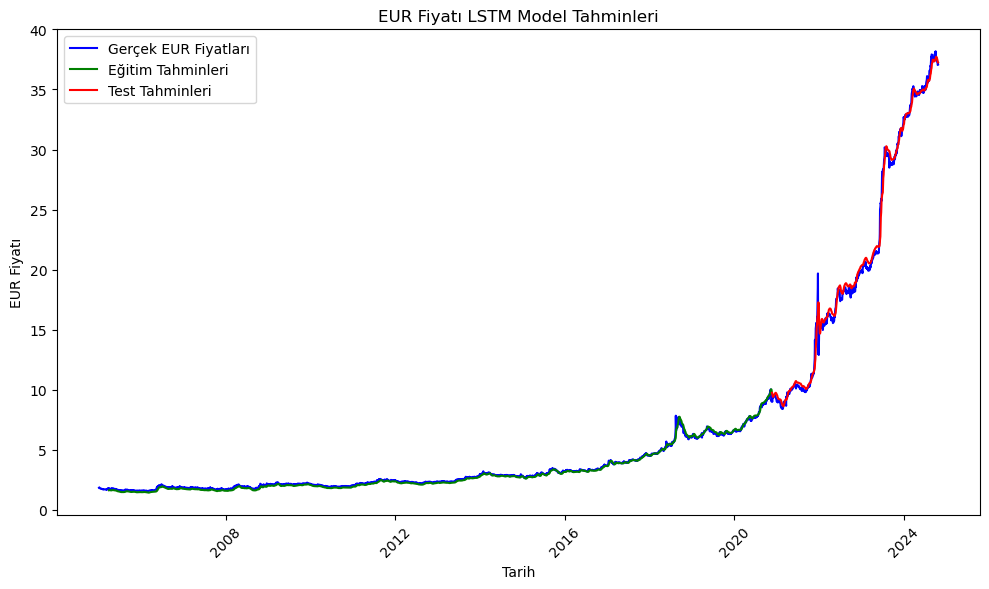

In [17]:
# Tahminler yapalım
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Verileri orijinal ölçeklerine geri çevirelim
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Eğitim ve test sonuçlarını görselleştirme
plt.figure(figsize=(10, 6))

# Gerçek fiyatları çizelim
plt.plot(df['Tarih'], df['EUR'], label='Gerçek EUR Fiyatları', color='blue')

# Eğitim ve test tahminlerini ekleyelim
plt.plot(df['Tarih'][time_step:train_size + time_step], train_predict, label='Eğitim Tahminleri', color='green')
plt.plot(df['Tarih'][train_size + time_step + 1:], test_predict, label='Test Tahminleri', color='red')

# Grafik ayarları
plt.xlabel('Tarih')
plt.ylabel('EUR Fiyatı')
plt.title('EUR Fiyatı LSTM Model Tahminleri')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Gerçek ve tahmin edilen değerlerin orijinal ölçeğine geri dönüştürülmesi
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Test verilerinin orijinal haline dönüşümü

# MSE ve R2 Score hesaplayın
mse = mean_squared_error(Y_test_inv, test_predict)  # Test verileri için MSE hesaplama
r2 = r2_score(Y_test_inv, test_predict)  # Test verileri için R2 score hesaplama

print(f"LSTM Model MSE: {mse}")
print(f"LSTM Model R2 Score: {r2}")


LSTM Model MSE: 0.2774481804017138
LSTM Model R2 Score: 0.996892536652728
